# Data Analysis

For our models, we are going to be analyzing layoff data alongside information
about both the US's foreign aid spending per year and US GDP data.

In [1]:
# for data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


/var/folders/94/smsw3ygd62x427m2vt3rdq100000gn/T/ipykernel_3703/400213315.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
layoff_data = pd.read_csv("tech_layoffs.csv")
layoff_data

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20 00:00:00 UTC,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369
1,4,InSightec,Haifa,Israel,Asia,100,2023-12-19 00:00:00 UTC,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18 00:00:00 UTC,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,7,Udaan,Bengaluru,India,Asia,100,2023-12-18 00:00:00 UTC,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369
4,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14 00:00:00 UTC,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,3286,Pitch,Berlin,Germany,Europe,80,2024-08-01 00:00:00 UTC,67.0,119,39,Other,Series B,$138,2024,52.52437,13.41053
1414,3287,BenchSci,Toronto,Canada,North America,70,2024-08-01 00:00:00 UTC,17.0,412,342,Healthcare,Series D,$164,2024,43.70643,-79.39864
1415,3288,NanoString Technology,Seattle,USA,North America,50,2024-08-01 00:00:00 UTC,9.0,556,506,Healthcare,Post-IPO,$826,2024,47.60621,-122.33207
1416,3289,Trigo,Tel Aviv,Israel,Asia,30,2024-04-01 00:00:00 UTC,15.0,200,170,Retail,Series C,$199,2024,32.08088,34.78057


In [3]:
layoff_data.shape

(1418, 16)

In [4]:
layoff_data.isna().sum()

#                              0
Company                        0
Location_HQ                    0
Country                        0
Continent                      0
Laid_Off                       0
Date_layoffs                   0
Percentage                     0
Company_Size_before_Layoffs    0
Company_Size_after_layoffs     0
Industry                       0
Stage                          0
Money_Raised_in_$_mil          0
Year                           0
lat                            0
lng                            0
dtype: int64

In [5]:
layoff_data.describe().round(2)

,#,Laid_Off,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Year,lat,lng
count,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00
mean,1823.41,267.39,21.90,3556.23,3288.84,2021.88,33.79,-59.65
std,922.67,877.47,20.66,22478.37,21878.26,1.15,18.81,74.47
min,3.00,3.00,0.04,4.00,0.00,2020.00,-41.29,-123.12
25%,1038.50,40.00,10.00,213.00,151.25,2022.00,34.05,-122.27
50%,1882.50,86.00,15.00,531.00,430.00,2022.00,37.77,-79.40
75%,2616.25,200.00,27.00,1414.75,1200.00,2023.00,42.33,-0.13
max,3290.00,12000.00,100.00,400000.00,392000.00,2024.00,60.17,174.78


In [6]:
# TODO: weekly price diff (%) parsing from NDXT (NASDAQ 100 Tech companies index); add into data_pd as a new column

# for stock price retrieval
from datetime import datetime, timedelta
import yfinance as yf

# initialize parameters 
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 12, 1)

# get the data 
stock_data = yf.download('^NDXT', start = start_date,
                   end = end_date)

stock_data.to_csv('stock_data.csv', index = True, encoding='utf-8') # False: not include index

# display 
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(start_date,
                                                end_date))
plt.plot(stock_data['Open'])
plt.show()

ModuleNotFoundError: No module named 'yfinance'

In [7]:
def date_to_index(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    for i in range(len(date_col_stock_data)):
        if date_col_stock_data[i] == date:
            return i
    return -1

def get_closest_available_date(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    # date_col_stock_data = stock_data.reset_index()['Date']
    while date not in date_col_stock_data:
        date = date - timedelta(days = 1)
    return date
    
"""
@param stock_data: original stock_data df
@param week_end: layoff date
@param period: number of days to look back, defaults to 7

@return % of change in NDXT index price during last week before layoff date 
"""
def weekly_price_diff(stock_data, week_end, period: int = 7):
    # week end date in format datetime(YYYY,MM,DD)

    if (week_end < datetime(2020, 1, 15)):
        return 0
    date_col_stock_data = stock_data.reset_index() # add DATE as column
    date_end_closest = get_closest_available_date(stock_data, week_end)
    date_start_closest = get_closest_available_date(stock_data, week_end - timedelta(days = period))
    
    price_end = stock_data['Open'][date_end_closest]
    price_start = stock_data['Open'][date_start_closest]
    price_diff = (price_end - price_start) / price_start * 100
    
    return price_diff # in PERCENTAGE
        
# ! USAGE EXAMPLE
price_diff = weekly_price_diff(stock_data, datetime(2022, 4, 11))
price_diff = round(price_diff, 2)
print(f"Diff between 11 APR 2022 and week before: {price_diff}%")

NameError: name 'stock_data' is not defined

In [8]:
# TODO: ADD RETRIEVED STOCK CHANGE TO DATA_PD

week_price_diff_df = pd.DataFrame(index = stock_data.index, columns = ['price_diff'])
for date in week_price_diff_df.index:
    week_price_diff_df.loc[date, 'price_diff'] = weekly_price_diff(stock_data, date)

stock_data['price_diff'] = week_price_diff_df['price_diff']
stock_data.to_csv('stock_data.csv', index = True, encoding='utf-8')
stock_data

NameError: name 'stock_data' is not defined

In [9]:
def str_to_datetime(dt_string):
    return datetime.strptime(dt_string, "%Y-%m-%d %H:%M:%S UTC")


layoff_data["Date_layoffs"] = layoff_data["Date_layoffs"].apply(lambda x: str_to_datetime(x))
layoff_data.set_index('Date_layoffs', inplace = True)
layoff_data = layoff_data.sort_index()
layoff_data

,#,Company,Location_HQ,Country,Continent,Laid_Off,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
Date_layoffs,,,,,,,,,,,,,,,
2020-03-12,3267,Tamara Mellon,Los Angeles,USA,North America,20,40.000000,50,30,Retail,Series C,$90,2020,34.05223,-118.24368
2020-03-13,3266,Panda Squad,San Francisco Bay Area,USA,North America,6,75.000000,8,2,Consumer,Seed,$1,2020,37.77493,-122.41942
2020-03-13,3265,HopSkipDrive,Los Angeles,USA,North America,8,10.000000,80,72,Transportation,Unknown,$45,2020,34.05223,-118.24368
2020-03-16,3262,Inspirato,Denver,USA,North America,130,22.000000,591,461,Travel,Series C,$79,2020,39.73915,-104.98470
2020-03-16,3263,Help.com,Austin,USA,North America,16,100.000000,16,0,Support,Seed,$6,2020,30.26715,-97.74306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,3279,Instagram,San Francisco Bay Area,USA,North America,60,13.333333,450,390,Consumer,Acquired,$57,2024,37.45383,-122.18219
2024-11-01,3272,Discord,San Francisco Bay Area,USA,North America,170,17.000000,1000,830,Consumer,Series H,$995,2024,37.77493,-122.41942
2024-11-01,3273,Inmobi,Bengaluru,India,Asia,125,5.000000,2500,2375,Marketing,Unknown,$320,2024,12.97194,77.59369


In [10]:
# TODO: NOW NEED TO ADD ACCORDING STOCK PRICE CHANGE TO LAYOFF_DATA
# layoff_data_with_date_col = layoff_data.reset_index()


In [11]:
# Extract percentage targets
layoff_target = layoff_data['Percentage']
layoff_target

Date_layoffs
2020-03-12     40.000000
2020-03-13     75.000000
2020-03-13     10.000000
2020-03-16     22.000000
2020-03-16    100.000000
                 ...    
2024-10-01     13.333333
2024-11-01     17.000000
2024-11-01      5.000000
2024-11-01      5.000000
2024-11-01     13.000000
Name: Percentage, Length: 1418, dtype: float64

In [14]:
# Drop target from remaining features
layoff_df = layoff_data.drop('Percentage', axis=1)
layoff_df

,#,Company,Location_HQ,Country,Continent,Laid_Off,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
Date_layoffs,,,,,,,,,,,,,,
2020-03-12,3267,Tamara Mellon,Los Angeles,USA,North America,20,50,30,Retail,Series C,$90,2020,34.05223,-118.24368
2020-03-13,3266,Panda Squad,San Francisco Bay Area,USA,North America,6,8,2,Consumer,Seed,$1,2020,37.77493,-122.41942
2020-03-13,3265,HopSkipDrive,Los Angeles,USA,North America,8,80,72,Transportation,Unknown,$45,2020,34.05223,-118.24368
2020-03-16,3262,Inspirato,Denver,USA,North America,130,591,461,Travel,Series C,$79,2020,39.73915,-104.98470
2020-03-16,3263,Help.com,Austin,USA,North America,16,16,0,Support,Seed,$6,2020,30.26715,-97.74306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,3279,Instagram,San Francisco Bay Area,USA,North America,60,450,390,Consumer,Acquired,$57,2024,37.45383,-122.18219
2024-11-01,3272,Discord,San Francisco Bay Area,USA,North America,170,1000,830,Consumer,Series H,$995,2024,37.77493,-122.41942
2024-11-01,3273,Inmobi,Bengaluru,India,Asia,125,2500,2375,Marketing,Unknown,$320,2024,12.97194,77.59369


In [30]:
# Describe features
layoff_df.describe().round(2)

,#,Laid_Off,Company_Size_before_Layoffs,Company_Size_after_layoffs,Year,lat,lng
count,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00
mean,1823.41,267.39,3556.23,3288.84,2021.88,33.79,-59.65
std,922.67,877.47,22478.37,21878.26,1.15,18.81,74.47
min,3.00,3.00,4.00,0.00,2020.00,-41.29,-123.12
25%,1038.50,40.00,213.00,151.25,2022.00,34.05,-122.27
50%,1882.50,86.00,531.00,430.00,2022.00,37.77,-79.40
75%,2616.25,200.00,1414.75,1200.00,2023.00,42.33,-0.13
max,3290.00,12000.00,400000.00,392000.00,2024.00,60.17,174.78


<Axes: xlabel='Percentage', ylabel='Count'>

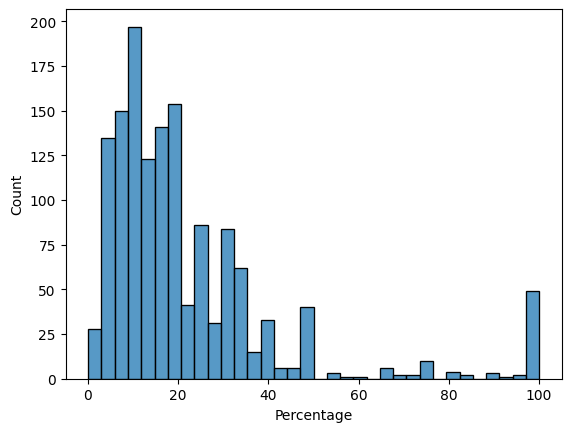

In [15]:
# Plot histogram of layoff percentages
sns.histplot(layoff_target)

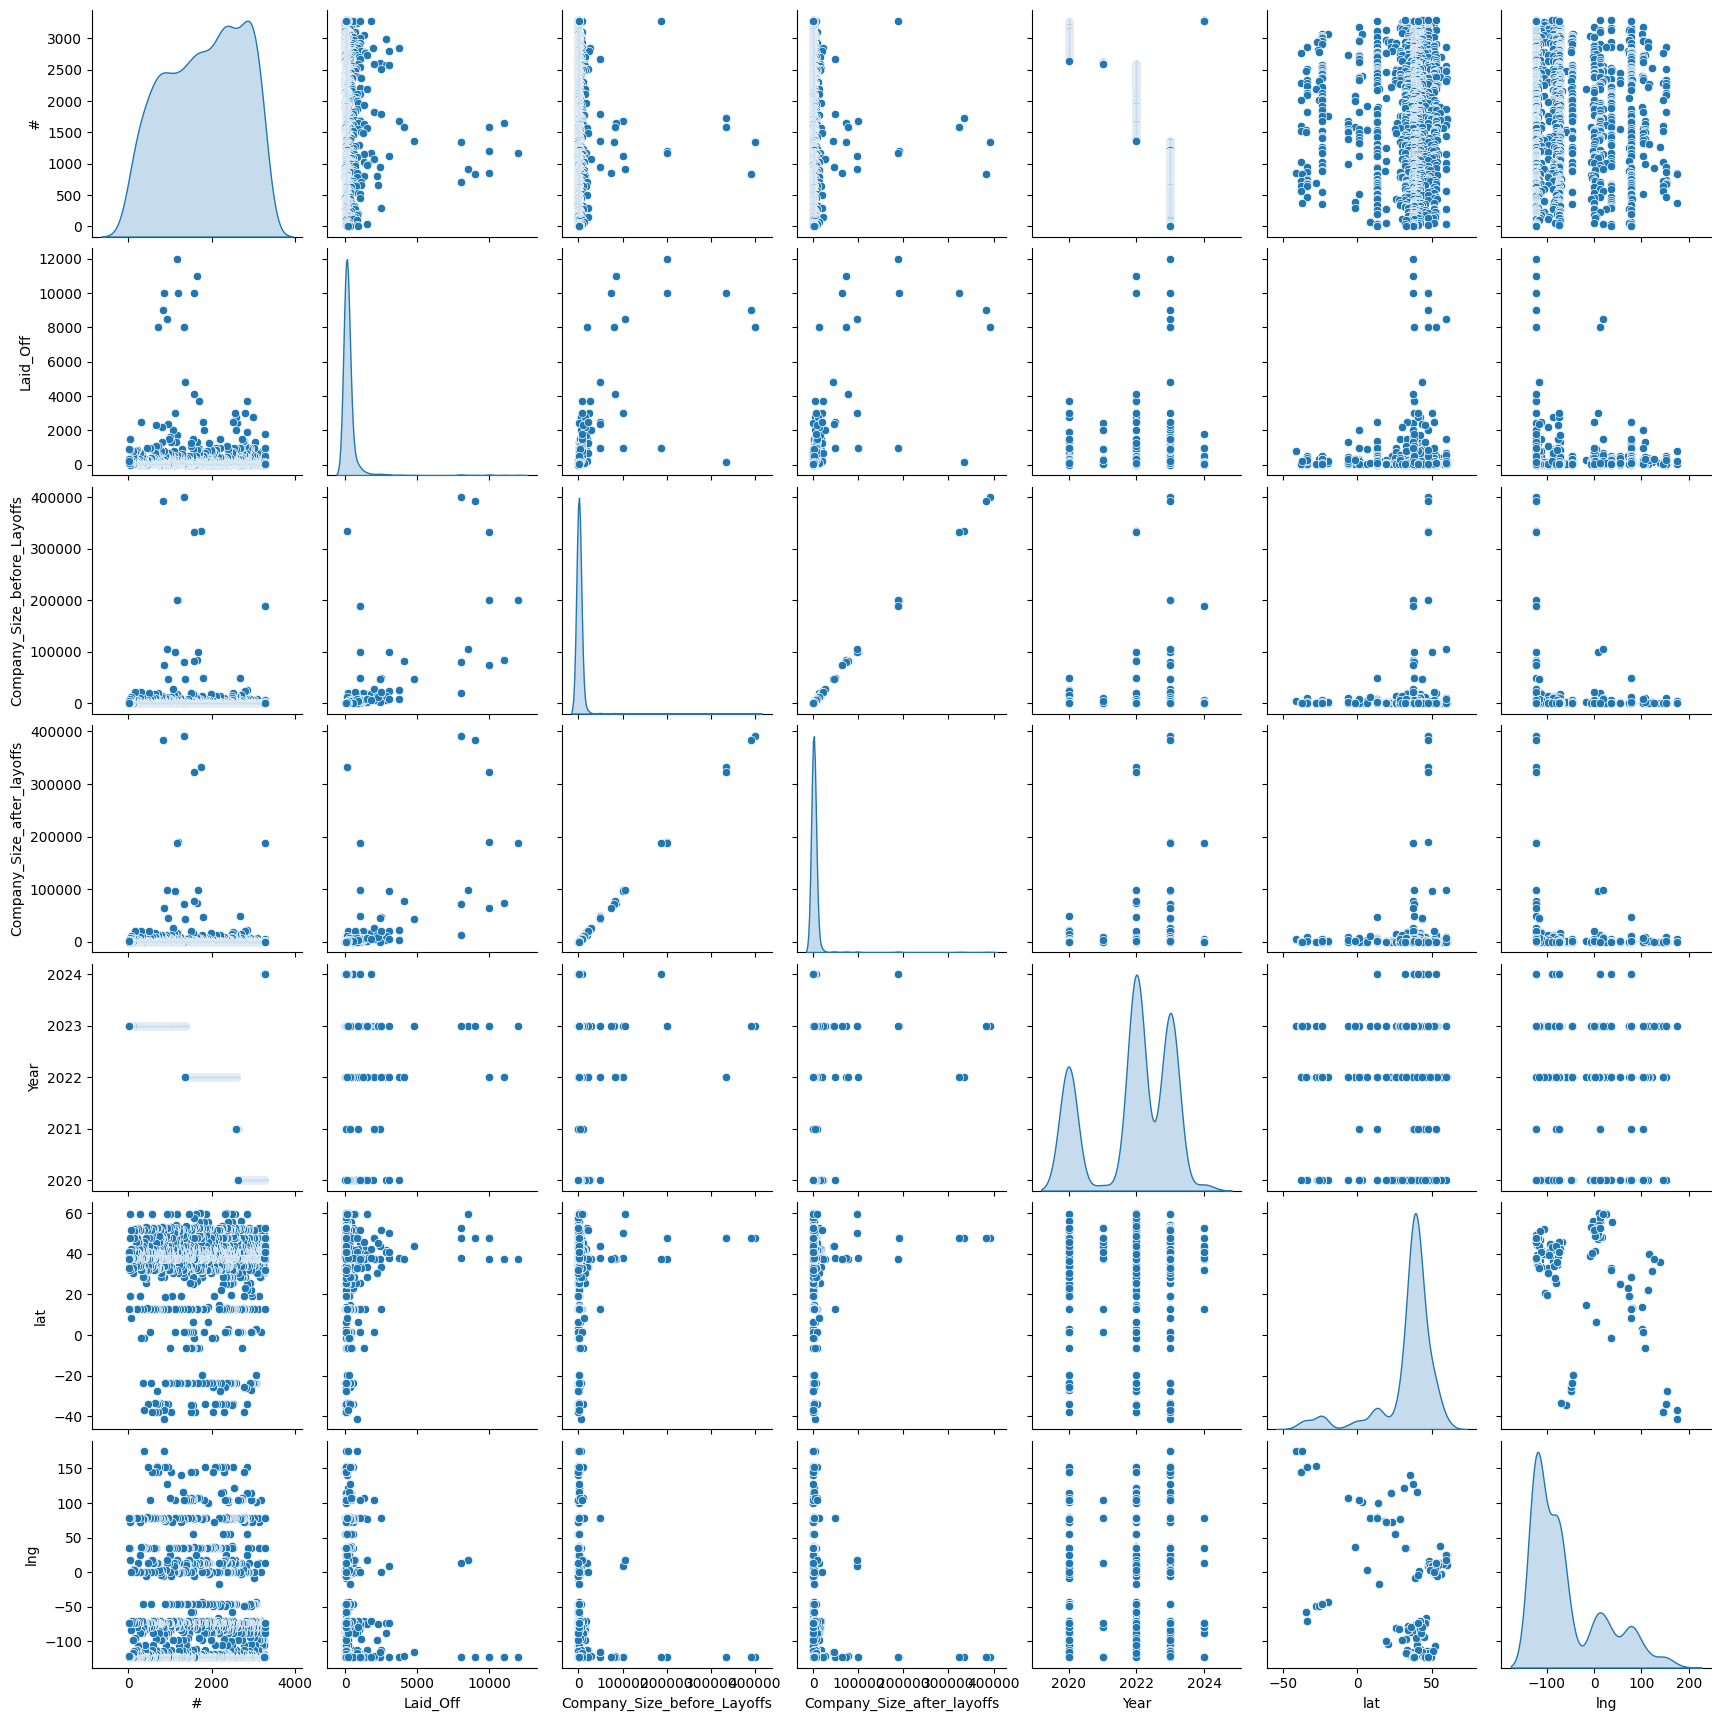

In [16]:
# Create pairplot of features
sns.pairplot(layoff_df, diag_kind='kde')

In [20]:
# Drop qualitative columns
dropped_cols = [
    'Company',
    'Location_HQ',
    'Country',
    'Continent',
    'Industry',
    'Stage',
]

corr_df = layoff_df.drop(columns=dropped_cols)

In [32]:
# Convert money to float for correlations
corr_df = corr_df.replace(to_replace='[\$]', value='', regex=True).astype(float)
corr_df

,#,Laid_Off,Company_Size_before_Layoffs,Company_Size_after_layoffs,Money_Raised_in_$_mil,Year,lat,lng
Date_layoffs,,,,,,,,
2020-03-12,3267.0,20.0,50.0,30.0,90.0,2020.0,34.05223,-118.24368
2020-03-13,3266.0,6.0,8.0,2.0,1.0,2020.0,37.77493,-122.41942
2020-03-13,3265.0,8.0,80.0,72.0,45.0,2020.0,34.05223,-118.24368
2020-03-16,3262.0,130.0,591.0,461.0,79.0,2020.0,39.73915,-104.98470
2020-03-16,3263.0,16.0,16.0,0.0,6.0,2020.0,30.26715,-97.74306
...,...,...,...,...,...,...,...,...
2024-10-01,3279.0,60.0,450.0,390.0,57.0,2024.0,37.45383,-122.18219
2024-11-01,3272.0,170.0,1000.0,830.0,995.0,2024.0,37.77493,-122.41942
2024-11-01,3273.0,125.0,2500.0,2375.0,320.0,2024.0,12.97194,77.59369


In [37]:
# Create correlation
corr = corr_df.corr()
corr

,#,Laid_Off,Company_Size_before_Layoffs,Company_Size_after_layoffs,Money_Raised_in_$_mil,Year,lat,lng
#,1.000000,-0.062037,-0.048502,-0.047344,0.007610,-0.825867,0.011037,-0.055777
Laid_Off,-0.062037,1.000000,0.694295,0.673233,0.135706,0.070815,0.047934,-0.052649
Company_Size_before_Layoffs,-0.048502,0.694295,1.000000,0.999583,0.051169,0.075515,0.051019,-0.064569
Company_Size_after_layoffs,-0.047344,0.673233,0.999583,1.000000,0.047130,0.074746,0.050496,-0.064229
Money_Raised_in_$_mil,0.007610,0.135706,0.051169,0.047130,1.000000,0.002570,0.013211,-0.029093
Year,-0.825867,0.070815,0.075515,0.074746,0.002570,1.000000,-0.007747,0.067282
lat,0.011037,0.047934,0.051019,0.050496,0.013211,-0.007747,1.000000,-0.472637
lng,-0.055777,-0.052649,-0.064569,-0.064229,-0.029093,0.067282,-0.472637,1.000000


<Axes: >

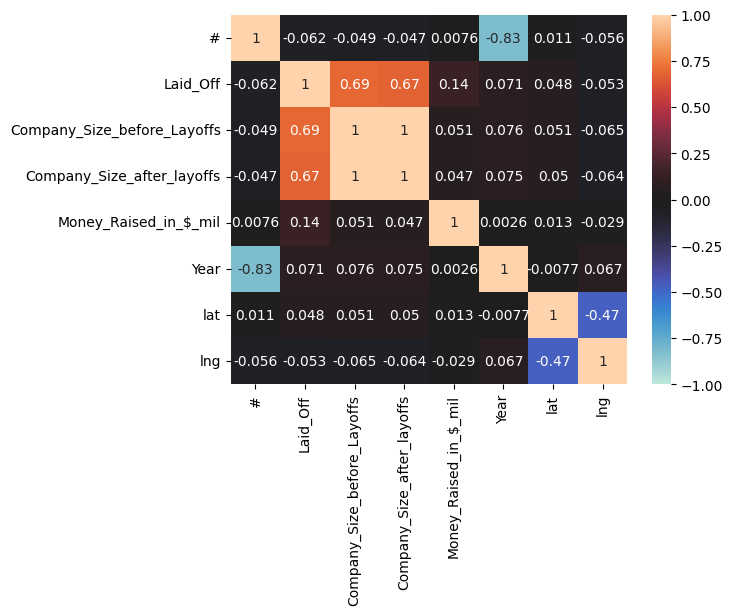

In [38]:
# Plot correlation onto heatmap
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True)

In [ ]:
# NOTE: May want to check correlation between layoff percentage and features